# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
parent_dir = os.path.abspath('..')
sys.path.insert(1, parent_dir)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, precision_score, recall_score
import shap
from imblearn.under_sampling import RandomUnderSampler
import re
from sklearn.utils.class_weight import compute_class_weight

c:\Users\Lisa Nguyen\.virtualenvs\OC-P7-5dK-jRoi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tools.functions import missing_values_summary, unique_value_counts, pct_null_buckets, test_scores

In [5]:
from tools import KernelPreproc

In [6]:
from tools.mlflow_tracking import log_model, log_model_wo_pipe

# Exploration

In [7]:
csv_path = os.path.join(parent_dir, "data")
file_names = [f for f in os.listdir(csv_path) if f.endswith(".csv")]
file_names

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'data.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## application_test

In [8]:
file = file_names[0]
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [10]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
47,COMMONAREA_AVG,33495,15249,68.716150
61,COMMONAREA_MODE,33495,15249,68.716150
75,COMMONAREA_MEDI,33495,15249,68.716150
55,NONLIVINGAPARTMENTS_AVG,33347,15397,68.412523
69,NONLIVINGAPARTMENTS_MODE,33347,15397,68.412523
...,...,...,...,...
14,NAME_HOUSING_TYPE,0,48744,0.000000
13,NAME_FAMILY_STATUS,0,48744,0.000000
12,NAME_EDUCATION_TYPE,0,48744,0.000000
11,NAME_INCOME_TYPE,0,48744,0.000000


## application_train

In [11]:
file = file_names[1]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [13]:
cols = ['SK_ID_CURR', 'TARGET']
temp = missing_values_summary(data, ascending=False)
temp[temp['index'].isin(cols)]

,index,Null_counts,Non_Null_counts,Percentage_Null
1,TARGET,0,307511,0.0
0,SK_ID_CURR,0,307511,0.0


In [14]:
unique_value_counts(data, 'TARGET')

,label,counts,percent,percent_cumul
0,0,282686,91.927118,91.927118
1,1,24825,8.072882,100.000000


In [15]:
data['SK_ID_CURR'].nunique()

307511

In the application_train dataset, there are 92% of the applications that are refused.

## bureau

In [16]:
file = file_names[2]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

bureau.csv


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [18]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
16,AMT_ANNUITY,1226791,489637,71.473490
8,AMT_CREDIT_MAX_OVERDUE,1124488,591940,65.513264
7,DAYS_ENDDATE_FACT,633653,1082775,36.916958
12,AMT_CREDIT_SUM_LIMIT,591780,1124648,34.477415
11,AMT_CREDIT_SUM_DEBT,257669,1458759,15.011932
6,DAYS_CREDIT_ENDDATE,105553,1610875,6.149573
10,AMT_CREDIT_SUM,13,1716415,0.000757
2,CREDIT_ACTIVE,0,1716428,0.000000
3,CREDIT_CURRENCY,0,1716428,0.000000
4,DAYS_CREDIT,0,1716428,0.000000


In [19]:
data['SK_ID_CURR'].nunique()

305811

## bureau_balance

In [20]:
file = file_names[3]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

bureau_balance.csv


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [22]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
0,SK_ID_BUREAU,0,27299925,0.0
1,MONTHS_BALANCE,0,27299925,0.0
2,STATUS,0,27299925,0.0


## credit_card_balance

In [23]:
file = file_names[4]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

credit_card_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [25]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
10,AMT_PAYMENT_CURRENT,767988,3072324,19.998063
5,AMT_DRAWINGS_ATM_CURRENT,749816,3090496,19.524872
18,CNT_DRAWINGS_POS_CURRENT,749816,3090496,19.524872
7,AMT_DRAWINGS_OTHER_CURRENT,749816,3090496,19.524872
8,AMT_DRAWINGS_POS_CURRENT,749816,3090496,19.524872
17,CNT_DRAWINGS_OTHER_CURRENT,749816,3090496,19.524872
15,CNT_DRAWINGS_ATM_CURRENT,749816,3090496,19.524872
19,CNT_INSTALMENT_MATURE_CUM,305236,3535076,7.948208
9,AMT_INST_MIN_REGULARITY,305236,3535076,7.948208
0,SK_ID_PREV,0,3840312,0.000000


## HomeCredit_columns_description

In [26]:
file = file_names[5]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path, encoding = 'unicode_escape')
data.head()

data.csv


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(621), int64(176)
memory usage: 1.8 GB


In [28]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
596,REFUSED_AMT_DOWN_PAYMENT_MAX,262339,45168,85.311554
597,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,45168,85.311554
595,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,45168,85.311554
606,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,45168,85.311554
605,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,45168,85.311554
...,...,...,...,...
179,ORGANIZATION_TYPE_Government,0,307507,0.000000
178,ORGANIZATION_TYPE_Emergency,0,307507,0.000000
177,ORGANIZATION_TYPE_Electricity,0,307507,0.000000
176,ORGANIZATION_TYPE_Culture,0,307507,0.000000


## installments_payments

In [31]:
file = file_names[6]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path, encoding = "ISO-8859-1")
data.head()

HomeCredit_columns_description.csv


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [33]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
4,Special,133,86,60.730594
0,Unnamed: 0,0,219,0.000000
1,Table,0,219,0.000000
2,Row,0,219,0.000000
3,Description,0,219,0.000000


## POS_CASH_balance

In [34]:
file = file_names[7]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

installments_payments.csv


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [36]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
5,DAYS_ENTRY_PAYMENT,2905,13602496,0.021352
7,AMT_PAYMENT,2905,13602496,0.021352
0,SK_ID_PREV,0,13605401,0.000000
1,SK_ID_CURR,0,13605401,0.000000
2,NUM_INSTALMENT_VERSION,0,13605401,0.000000
3,NUM_INSTALMENT_NUMBER,0,13605401,0.000000
4,DAYS_INSTALMENT,0,13605401,0.000000
6,AMT_INSTALMENT,0,13605401,0.000000


## previous_application

In [37]:
file = file_names[8]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

POS_CASH_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [39]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
4,CNT_INSTALMENT_FUTURE,26087,9975271,0.260835
3,CNT_INSTALMENT,26071,9975287,0.260675
0,SK_ID_PREV,0,10001358,0.000000
1,SK_ID_CURR,0,10001358,0.000000
2,MONTHS_BALANCE,0,10001358,0.000000
5,NAME_CONTRACT_STATUS,0,10001358,0.000000
6,SK_DPD,0,10001358,0.000000
7,SK_DPD_DEF,0,10001358,0.000000


## sample_submission

In [40]:
file = file_names[9]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

previous_application.csv


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [42]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
14,RATE_INTEREST_PRIVILEGED,1664263,5951,99.643698
13,RATE_INTEREST_PRIMARY,1664263,5951,99.643698
6,AMT_DOWN_PAYMENT,895844,774370,53.636480
12,RATE_DOWN_PAYMENT,895844,774370,53.636480
20,NAME_TYPE_SUITE,820405,849809,49.119754
36,NFLAG_INSURED_ON_APPROVAL,673065,997149,40.298129
35,DAYS_TERMINATION,673065,997149,40.298129
34,DAYS_LAST_DUE,673065,997149,40.298129
33,DAYS_LAST_DUE_1ST_VERSION,673065,997149,40.298129
32,DAYS_FIRST_DUE,673065,997149,40.298129


In [44]:
# data['TARGET'].value_counts()

KeyError: 'TARGET'

# Data preprocessing

In [7]:
file_path = os.path.join(parent_dir, "data", "data.csv")

In [8]:
# data = KernelPreproc.main()
# data.to_csv(file_path, index=False)

In [9]:
data = pd.read_csv(file_path)
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing data

<AxesSubplot: xlabel='Percentage_Null', ylabel='Count'>

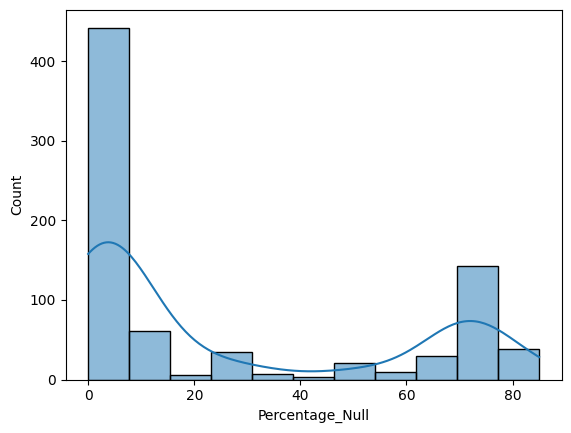

In [10]:
temp = missing_values_summary(data, ascending=False)
temp['Percentage_Null'] = temp['Percentage_Null'].apply(lambda x: round(x,0))
sns.histplot(temp['Percentage_Null'], kde=True)

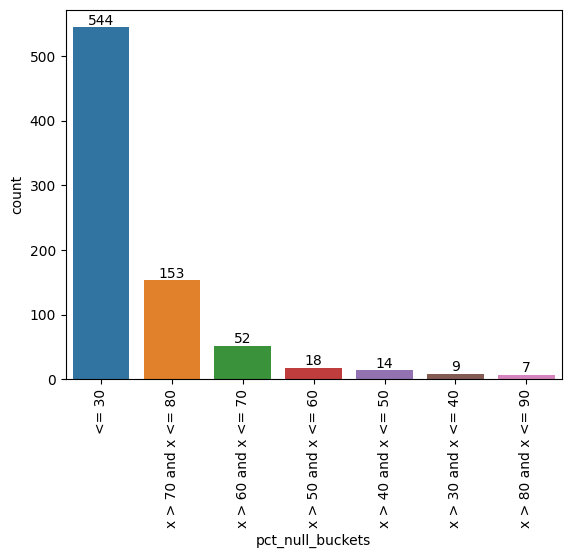

In [11]:
temp['pct_null_buckets'] = temp['Percentage_Null'].apply(lambda x: pct_null_buckets(x))

ax = sns.countplot(x=temp['pct_null_buckets'],
                   order=temp['pct_null_buckets'].value_counts(ascending=False).index)
abs_values = temp['pct_null_buckets'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.xticks(rotation=90);

In [12]:
cols_to_drop = list(temp[temp['Percentage_Null'] > 30]['index'])
cols = list(data.columns)
cols_to_keep = [col for col in cols if col not in cols_to_drop]

print(f"nb cols_to_drop: {len(cols_to_drop)}")
print(f"nb cols: {len(cols)}")
print(f"nb cols_to_keep: {len(cols_to_keep)}")

nb cols_to_drop: 253
nb cols: 797
nb cols_to_keep: 544


In [13]:
df = data.copy()
df = df[cols_to_keep]
df.shape

(307507, 544)

## Outliers

In [14]:
temp = df.describe()
temp.loc['max'].max()

inf

In [15]:
# Drop inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
# Check
temp = df.describe()
temp.loc['max'].max()

445993643959.2246

## Data

In [68]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Simulation

In [70]:
# !cd .\OC-P7\notebooks
# !pipenv shell
# !mlflow ui

## Dummy

In [71]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train)
X_train_imputer = imputer.transform(X_train)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_imputer, y_train)

X_test_imputer = imputer.transform(X_test)
y_pred = dummy.predict(X_test_imputer)

print("accuracy_score:", dummy.score(X_train, y_train))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.9191909118501496
accuracy_score: 0.9195077851633128
fbeta_score: 0.0
fbeta_score: 0.0


## LGBM

In [72]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 11m

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier()_16:49:10
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


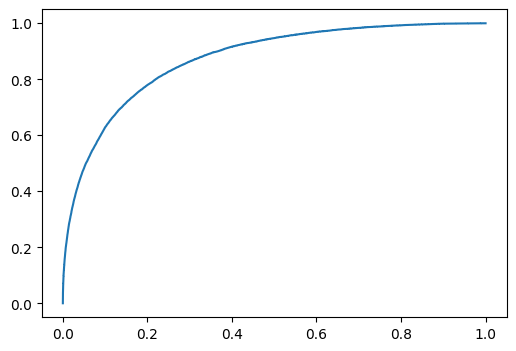

In [74]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [75]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.9347789325806158
fbeta_score: 0.23061523061523065


,score,value
0,accuracy_score,0.934779
1,fbeta_score,0.230615


## Catboost

In [76]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 19m

0:	learn: 0.6569658	total: 170ms	remaining: 16.8s
1:	learn: 0.6132520	total: 318ms	remaining: 15.6s
2:	learn: 0.5834423	total: 459ms	remaining: 14.8s
3:	learn: 0.5586644	total: 596ms	remaining: 14.3s
4:	learn: 0.5342304	total: 720ms	remaining: 13.7s
5:	learn: 0.5101537	total: 852ms	remaining: 13.3s
6:	learn: 0.4891372	total: 985ms	remaining: 13.1s
7:	learn: 0.4685301	total: 1.11s	remaining: 12.8s
8:	learn: 0.4526786	total: 1.24s	remaining: 12.5s
9:	learn: 0.4354156	total: 1.38s	remaining: 12.4s
10:	learn: 0.4220177	total: 1.52s	remaining: 12.3s
11:	learn: 0.4096885	total: 1.64s	remaining: 12s
12:	learn: 0.3967084	total: 1.75s	remaining: 11.7s
13:	learn: 0.3892758	total: 1.88s	remaining: 11.5s
14:	learn: 0.3782245	total: 2s	remaining: 11.3s
15:	learn: 0.3668132	total: 2.13s	remaining: 11.2s
16:	learn: 0.3563230	total: 2.26s	remaining: 11s
17:	learn: 0.3469986	total: 2.38s	remaining: 10.8s
18:	learn: 0.3346236	total: 2.5s	remaining: 10.7s
19:	learn: 0.3259643	total: 2.64s	remaining: 10.6

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015E4CB610>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015E4CB610>_17:08:42
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.5773897	total: 1.39s	remaining: 2m 17s
1:	learn: 0.5102399	total: 2.88s	remaining: 2m 21s
2:	learn: 0.4440936	total: 4.38s	remaining: 2m 21s
3:	learn: 0.3875359	total: 5.78s	remaining: 2m 18s
4:	learn: 0.3502808	total: 7.26s	remaining: 2m 17s
5:	learn: 0.3216891	total: 8.73s	remaining: 2m 16s
6:	learn: 0.2959698	total: 10.1s	remaining: 2m 13s
7:	learn: 0.2787514	total: 11.4s	remaining: 2m 11s
8:	learn: 0.2635449	total: 12.8s	remaining: 2m 9s
9:	learn: 0.2535211	total: 14.2s	remaining: 2m 7s
10:	learn: 0.2444066	total: 15.5s	remaining: 2m 5s
11:	learn: 0.2352662	total: 16.9s	remaining: 2m 3s
12:	learn: 0.2289

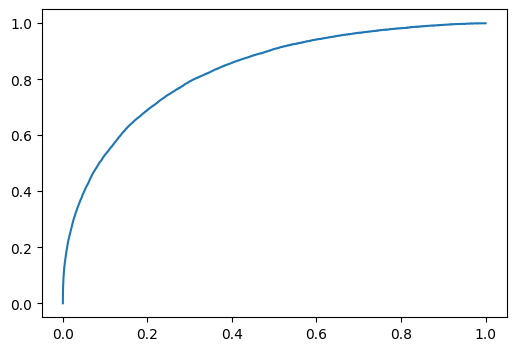

In [77]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [78]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.5799917	total: 1.37s	remaining: 2m 15s
1:	learn: 0.4976403	total: 2.8s	remaining: 2m 17s
2:	learn: 0.4382479	total: 4.22s	remaining: 2m 16s
3:	learn: 0.3876425	total: 5.65s	remaining: 2m 15s
4:	learn: 0.3493496	total: 6.99s	remaining: 2m 12s
5:	learn: 0.3220528	total: 8.35s	remaining: 2m 10s
6:	learn: 0.2986647	total: 9.66s	remaining: 2m 8s
7:	learn: 0.2800033	total: 11.1s	remaining: 2m 7s
8:	learn: 0.2664470	total: 12.4s	remaining: 2m 5s
9:	learn: 0.2548169	total: 13.8s	remaining: 2m 3s
10:	learn: 0.2446965	total: 15.1s	remaining: 2m 2s
11:	learn: 0.2347856	total: 16.4s	remaining: 2m
12:	learn: 0.2278948	total: 17.7s	remaining: 1m 58s
13:	learn: 0.2217353	total: 19.1s	remaining: 1m 57s
14:	learn: 0.2171717	total: 20.4s	remaining: 1m 55s
15:	learn: 0.2122680	total: 21.8s	remaining: 1m 54s
16:	learn: 0.2091493	total: 23.1s	remaining: 1m 52s
17:	learn: 0.2064740	total: 24.5s	remaining: 1m 51s
18:	learn: 0.2040936	total: 25.8s	remaining: 1m 49s
19:	learn: 0.2016633	total: 27.2

,score,value
0,accuracy_score,0.927742
1,fbeta_score,0.125802


## RandomForest

In [79]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit time: 19min

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(n_estimators=50)_17:33:27
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


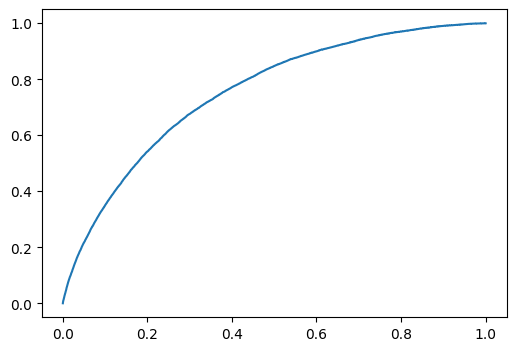

In [80]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [81]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9198589955383275
fbeta_score: 0.010271075844846338


,score,value
0,accuracy_score,0.919859
1,fbeta_score,0.010271


# Undersampling

## Data

In [175]:
print(df.shape)
df_wo_na = df.dropna()
print(df_wo_na.shape)

(307507, 544)
(102240, 544)


In [176]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [178]:
rus = RandomUnderSampler(random_state=0, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 70487, 1: 6193})
Resample dataset shape Counter({0: 6193, 1: 6193})


In [179]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_rus.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_rus = X_rus.rename(columns=new_names)

In [180]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

## Dummy

In [181]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_rus, y_rus)

y_pred = dummy.predict(X_test)

print("accuracy_score:", dummy.score(X_rus, y_rus))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.5
accuracy_score: 0.9185446009389672
fbeta_score: 0.0


## LGBM

In [88]:
pipe = Pipeline([
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier()_17:38:53
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


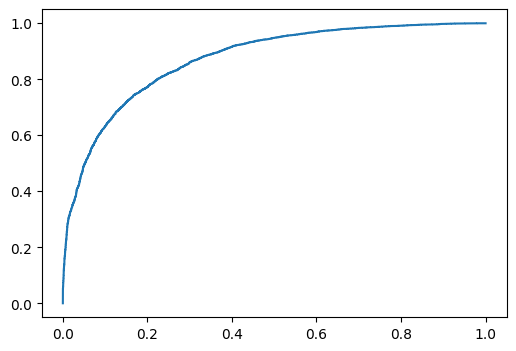

In [89]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [90]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.9384976525821597
fbeta_score: 0.29102622061482813


,score,value
0,accuracy_score,0.938498
1,fbeta_score,0.291026


## Catboost

In [91]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

0:	learn: 0.6885250	total: 21.2ms	remaining: 2.1s
1:	learn: 0.6843903	total: 36.1ms	remaining: 1.77s
2:	learn: 0.6807620	total: 57.6ms	remaining: 1.86s
3:	learn: 0.6774964	total: 74ms	remaining: 1.77s
4:	learn: 0.6740294	total: 91.1ms	remaining: 1.73s
5:	learn: 0.6710307	total: 107ms	remaining: 1.67s
6:	learn: 0.6683020	total: 122ms	remaining: 1.62s
7:	learn: 0.6655597	total: 137ms	remaining: 1.57s
8:	learn: 0.6630679	total: 154ms	remaining: 1.56s
9:	learn: 0.6606860	total: 170ms	remaining: 1.53s
10:	learn: 0.6581075	total: 186ms	remaining: 1.5s
11:	learn: 0.6561172	total: 201ms	remaining: 1.47s
12:	learn: 0.6540970	total: 216ms	remaining: 1.45s
13:	learn: 0.6521613	total: 232ms	remaining: 1.43s
14:	learn: 0.6503892	total: 249ms	remaining: 1.41s
15:	learn: 0.6482565	total: 268ms	remaining: 1.41s
16:	learn: 0.6461074	total: 287ms	remaining: 1.4s
17:	learn: 0.6447633	total: 302ms	remaining: 1.38s
18:	learn: 0.6432299	total: 319ms	remaining: 1.36s
19:	learn: 0.6415731	total: 334ms	remaini

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015F251910>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015F251910>_17:43:02
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.5925279	total: 379ms	remaining: 37.5s
1:	learn: 0.5180155	total: 739ms	remaining: 36.2s
2:	learn: 0.4619648	total: 1.13s	remaining: 36.7s
3:	learn: 0.4144260	total: 1.5s	remaining: 36s
4:	learn: 0.3775144	total: 1.84s	remaining: 35s
5:	learn: 0.3520426	total: 2.19s	remaining: 34.3s
6:	learn: 0.3299204	total: 2.58s	remaining: 34.3s
7:	learn: 0.3142871	total: 3.05s	remaining: 35.1s
8:	learn: 0.2994394	total: 3.53s	remaining: 35.7s
9:	learn: 0.2882134	total: 4s	remaining: 36s
10:	learn: 0.2790235	total: 4.48s	remaining: 36.2s
11:	learn: 0.2706414	total: 4.97s	remaining: 36.4s
12:	learn: 0.2650149	total: 5.46s	r

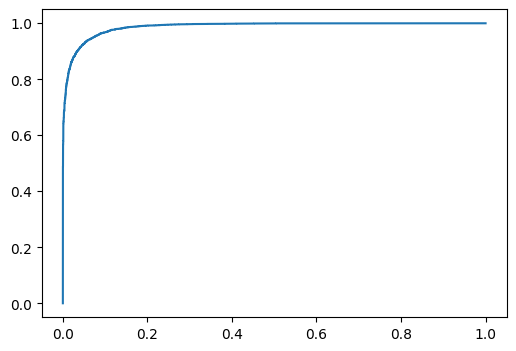

In [92]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [93]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.5925279	total: 506ms	remaining: 50.1s
1:	learn: 0.5180155	total: 1.07s	remaining: 52.3s
2:	learn: 0.4619648	total: 1.64s	remaining: 53.1s
3:	learn: 0.4144260	total: 2.11s	remaining: 50.7s
4:	learn: 0.3775144	total: 2.6s	remaining: 49.5s
5:	learn: 0.3520426	total: 3.16s	remaining: 49.5s
6:	learn: 0.3299204	total: 3.64s	remaining: 48.4s
7:	learn: 0.3142871	total: 4.14s	remaining: 47.6s
8:	learn: 0.2994394	total: 4.67s	remaining: 47.2s
9:	learn: 0.2882134	total: 5.14s	remaining: 46.3s
10:	learn: 0.2790235	total: 5.61s	remaining: 45.4s
11:	learn: 0.2706414	total: 6.08s	remaining: 44.6s
12:	learn: 0.2650149	total: 6.55s	remaining: 43.9s
13:	learn: 0.2584668	total: 7.05s	remaining: 43.3s
14:	learn: 0.2531722	total: 7.53s	remaining: 42.7s
15:	learn: 0.2482702	total: 8s	remaining: 42s
16:	learn: 0.2434214	total: 8.49s	remaining: 41.4s
17:	learn: 0.2406757	total: 8.97s	remaining: 40.9s
18:	learn: 0.2373971	total: 9.44s	remaining: 40.2s
19:	learn: 0.2336232	total: 9.92s	remaining: 39

,score,value
0,accuracy_score,0.942723
1,fbeta_score,0.345406


## RandomForest

In [94]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(n_estimators=50)_17:45:18
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


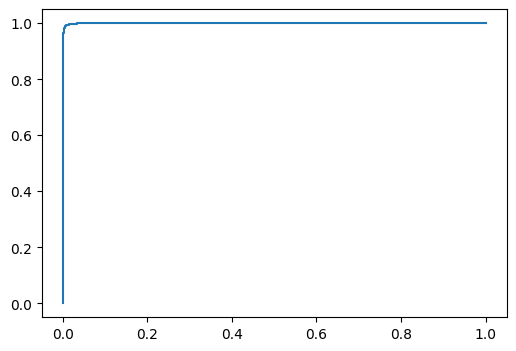

In [95]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [96]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9300860719874804
fbeta_score: 0.1710541574857938


,score,value
0,accuracy_score,0.930086
1,fbeta_score,0.171054


# Class Weights

## Data

In [182]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [184]:
print('original dataset shape:', Counter(y_train))
print('weight class 0:', f'{Counter(y_train)[0]/y_train.shape[0]:.2f}', 'weight class 1:', f'{Counter(y_train)[1]/y_train.shape[0]:.2f}')

original dataset shape: Counter({0: 70487, 1: 6193})
weight class 0: 0.92 weight class 1: 0.08


In [185]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5439300863989104, 1: 6.1908606491199745}

In [186]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_train = X_train.rename(columns=new_names)

In [187]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

## Dummy

In [188]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

print("accuracy_score:", dummy.score(X_train, y_train))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.9192357850808555
accuracy_score: 0.9185446009389672
fbeta_score: 0.0


## LGBM

In [103]:
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced')),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier(class_weight='balanced')_17:47:40
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


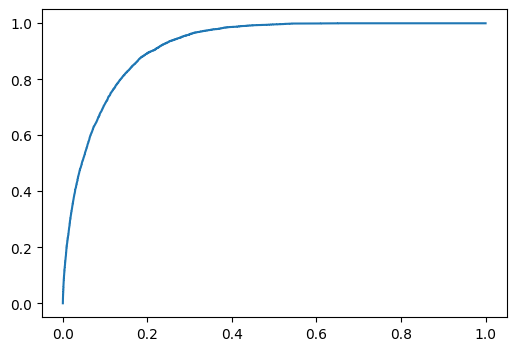

In [104]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [105]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.8798122065727699
fbeta_score: 0.7594889420203228


,score,value
0,accuracy_score,0.879812
1,fbeta_score,0.759489


## Catboost

In [106]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100, class_weights=class_weights)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

0:	learn: 0.6891834	total: 33.9ms	remaining: 3.35s
1:	learn: 0.6847271	total: 61.4ms	remaining: 3.01s
2:	learn: 0.6807672	total: 89.7ms	remaining: 2.9s
3:	learn: 0.6774739	total: 117ms	remaining: 2.81s
4:	learn: 0.6740395	total: 150ms	remaining: 2.84s
5:	learn: 0.6708415	total: 183ms	remaining: 2.87s
6:	learn: 0.6676961	total: 213ms	remaining: 2.83s
7:	learn: 0.6646888	total: 243ms	remaining: 2.79s
8:	learn: 0.6619007	total: 276ms	remaining: 2.79s
9:	learn: 0.6592362	total: 305ms	remaining: 2.74s
10:	learn: 0.6570068	total: 330ms	remaining: 2.67s
11:	learn: 0.6549860	total: 363ms	remaining: 2.66s
12:	learn: 0.6528567	total: 388ms	remaining: 2.6s
13:	learn: 0.6506084	total: 417ms	remaining: 2.56s
14:	learn: 0.6486299	total: 445ms	remaining: 2.52s
15:	learn: 0.6466767	total: 474ms	remaining: 2.49s
16:	learn: 0.6449005	total: 507ms	remaining: 2.48s
17:	learn: 0.6432341	total: 535ms	remaining: 2.44s
18:	learn: 0.6419604	total: 563ms	remaining: 2.4s
19:	learn: 0.6403189	total: 591ms	remaini

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015F18AF70>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015F18AF70>_17:51:50
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.6797929	total: 22.1ms	remaining: 2.19s
1:	learn: 0.6696979	total: 41.1ms	remaining: 2.02s
2:	learn: 0.6601288	total: 63.9ms	remaining: 2.06s
3:	learn: 0.6527124	total: 85.9ms	remaining: 2.06s
4:	learn: 0.6462367	total: 106ms	remaining: 2.01s
5:	learn: 0.6408673	total: 126ms	remaining: 1.97s
6:	learn: 0.6367610	total: 144ms	remaining: 1.91s
7:	learn: 0.6326556	total: 165ms	remaining: 1.9s
8:	learn: 0.6287493	total: 188ms	remaining: 1.9s
9:	learn: 0.6250504	total: 208ms	remaining: 1.88s
10:	learn: 0.6218481	total: 226ms	remaining: 1.83s
11:	learn: 0.6198465	total: 245ms	remaining: 1.8s
12:	learn: 0.6168180	tot

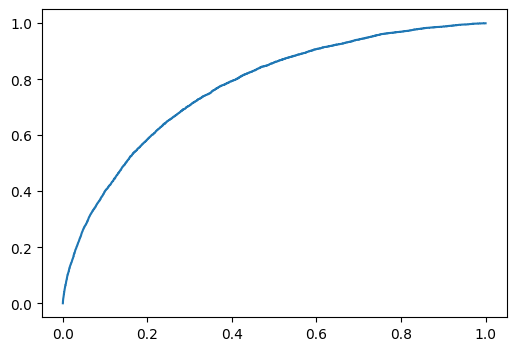

In [107]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [108]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.6797929	total: 27.8ms	remaining: 2.75s
1:	learn: 0.6696979	total: 53.2ms	remaining: 2.61s
2:	learn: 0.6601288	total: 77.5ms	remaining: 2.5s
3:	learn: 0.6527124	total: 108ms	remaining: 2.6s
4:	learn: 0.6462367	total: 140ms	remaining: 2.67s
5:	learn: 0.6408673	total: 176ms	remaining: 2.76s
6:	learn: 0.6367610	total: 200ms	remaining: 2.65s
7:	learn: 0.6326556	total: 226ms	remaining: 2.6s
8:	learn: 0.6287493	total: 250ms	remaining: 2.53s
9:	learn: 0.6250504	total: 277ms	remaining: 2.49s
10:	learn: 0.6218481	total: 301ms	remaining: 2.43s
11:	learn: 0.6198465	total: 324ms	remaining: 2.38s
12:	learn: 0.6168180	total: 348ms	remaining: 2.33s
13:	learn: 0.6143885	total: 374ms	remaining: 2.3s
14:	learn: 0.6125718	total: 401ms	remaining: 2.27s
15:	learn: 0.6105290	total: 426ms	remaining: 2.24s
16:	learn: 0.6086832	total: 451ms	remaining: 2.2s
17:	learn: 0.6061233	total: 478ms	remaining: 2.18s
18:	learn: 0.6044777	total: 504ms	remaining: 2.15s
19:	learn: 0.6030223	total: 529ms	remaining

,score,value
0,accuracy_score,0.728404
1,fbeta_score,0.475810


## RandomForest

In [109]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50, class_weight='balanced')),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(class_weight='balanced', n_estimators=50)_17:56:40
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


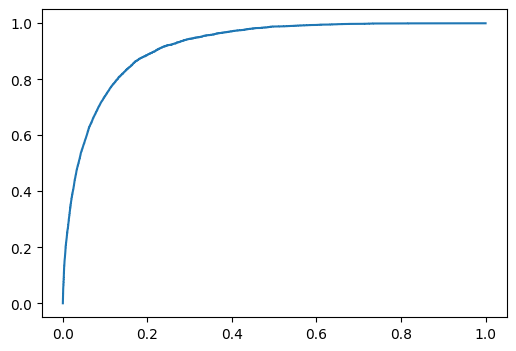

In [110]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [111]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9348982785602504
fbeta_score: 0.7738303072625697


,score,value
0,accuracy_score,0.934898
1,fbeta_score,0.773830


# Best model

In [119]:
best_model = search.best_estimator_[0]
best_model

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=50)

In [114]:
# best_model = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, n_estimators=50)
# best_model

## Optimal threshold

In [120]:
thresholds = list(np.arange(0.1, 1.0, 0.1))
thresholds_list = []
scores_list = []

y_prob = best_model.predict_proba(X_test) #ou sur train ?

for threshold in thresholds:
    y_pred = (y_prob[:,1]>=threshold).astype(int)
    score = fbeta_score(y_test, y_pred, beta=2)

    thresholds_list.append(threshold)
    scores_list.append(score)

thresholds_df = pd.DataFrame({"threshold": thresholds_list, "score": scores_list})
thresholds_df

,threshold,score
0,0.1,0.310561
1,0.2,0.372985
2,0.3,0.528924
3,0.4,0.713142
4,0.5,0.773830
5,0.6,0.552803
6,0.7,0.169981
7,0.8,0.003600
8,0.9,0.000000


## Feature importance

In [ ]:
# lgbm_best_model.best_estimator_.steps[2][1].feature_importances_
# lgbm_best_model.best_estimator_.steps[2][1]

LGBMClassifier(max_depth=10, min_data_in_leaf=100, num_leaves=500)

In [ ]:
# best_model = search.best_estimator_['model']
# best_model

LGBMClassifier()

In [124]:
# choosen_instance = X.loc[[0]]
choosen_instance = df.loc[[0]]

# explainer = shap.TreeExplainer(best_model.best_estimator_.steps[2][1])
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

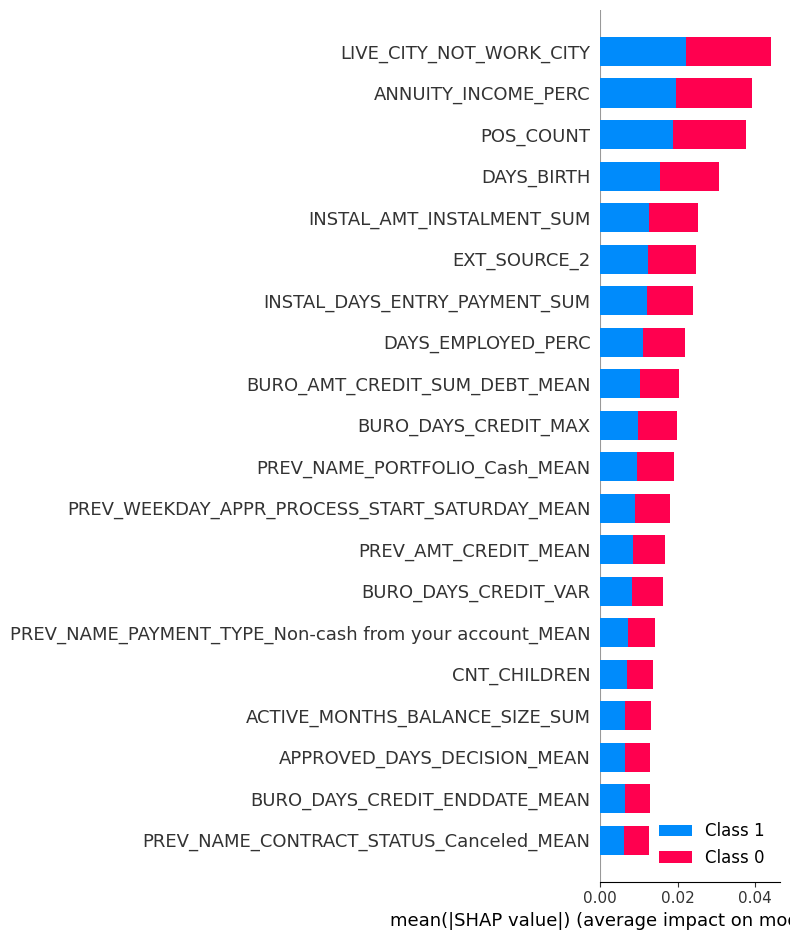

In [125]:
shap.summary_plot(shap_values, df, plot_type='bar')
# shap.summary_plotc

# Minimum

## Data

In [126]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Simulation

## Dummy

In [128]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train)
X_train_imputer = imputer.transform(X_train)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_imputer, y_train)

X_test_imputer = imputer.transform(X_test)
y_pred = dummy.predict(X_test_imputer)

print("accuracy_score:", dummy.score(X_train, y_train))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=0.5)) # precision FP
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.9191909118501496
accuracy_score: 0.9195077851633128
fbeta_score: 0.0
fbeta_score: 0.0


## LGBM

In [129]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 15m

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier()_18:41:49
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


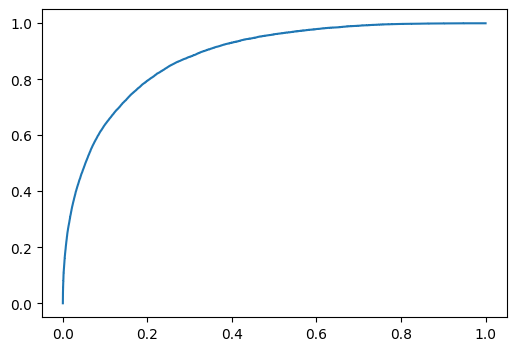

In [130]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [131]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.9268701952469529
fbeta_score: 0.12267044114177872


,score,value
0,accuracy_score,0.92687
1,fbeta_score,0.12267


## Catboost

In [132]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 15m

0:	learn: 0.6567209	total: 129ms	remaining: 12.7s
1:	learn: 0.6134720	total: 248ms	remaining: 12.2s
2:	learn: 0.5874439	total: 371ms	remaining: 12s
3:	learn: 0.5612908	total: 482ms	remaining: 11.6s
4:	learn: 0.5413113	total: 600ms	remaining: 11.4s
5:	learn: 0.5120073	total: 713ms	remaining: 11.2s
6:	learn: 0.4932286	total: 815ms	remaining: 10.8s
7:	learn: 0.4755472	total: 922ms	remaining: 10.6s
8:	learn: 0.4549243	total: 1.03s	remaining: 10.5s
9:	learn: 0.4411723	total: 1.14s	remaining: 10.3s
10:	learn: 0.4258183	total: 1.25s	remaining: 10.1s
11:	learn: 0.4144254	total: 1.35s	remaining: 9.92s
12:	learn: 0.4000891	total: 1.46s	remaining: 9.77s
13:	learn: 0.3908199	total: 1.56s	remaining: 9.6s
14:	learn: 0.3792219	total: 1.66s	remaining: 9.39s
15:	learn: 0.3729038	total: 1.76s	remaining: 9.22s
16:	learn: 0.3610970	total: 1.87s	remaining: 9.14s
17:	learn: 0.3483312	total: 1.97s	remaining: 8.99s
18:	learn: 0.3401359	total: 2.07s	remaining: 8.81s
19:	learn: 0.3346164	total: 2.17s	remaining:

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015E52F9A0>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015E52F9A0>_18:57:49
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.6589818	total: 87.4ms	remaining: 8.65s
1:	learn: 0.6153417	total: 172ms	remaining: 8.44s
2:	learn: 0.5867573	total: 257ms	remaining: 8.32s
3:	learn: 0.5599576	total: 348ms	remaining: 8.36s
4:	learn: 0.5373624	total: 440ms	remaining: 8.36s
5:	learn: 0.5166358	total: 524ms	remaining: 8.21s
6:	learn: 0.4982937	total: 610ms	remaining: 8.11s
7:	learn: 0.4734358	total: 696ms	remaining: 8s
8:	learn: 0.4546051	total: 787ms	remaining: 7.96s
9:	learn: 0.4350038	total: 882ms	remaining: 7.93s
10:	learn: 0.4222943	total: 980ms	remaining: 7.93s
11:	learn: 0.4120529	total: 1.06s	remaining: 7.79s
12:	learn: 0.3993405	total:

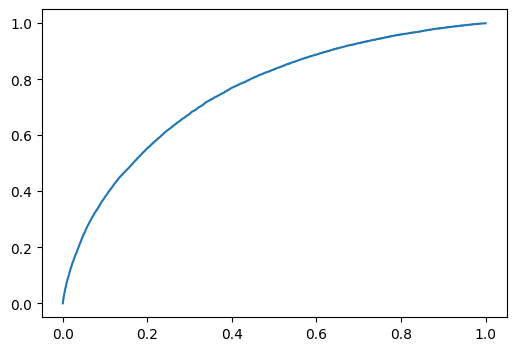

In [133]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [134]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.6577106	total: 99ms	remaining: 9.8s
1:	learn: 0.6235644	total: 190ms	remaining: 9.32s
2:	learn: 0.5953744	total: 283ms	remaining: 9.15s
3:	learn: 0.5668374	total: 380ms	remaining: 9.11s
4:	learn: 0.5423458	total: 471ms	remaining: 8.95s
5:	learn: 0.5141649	total: 566ms	remaining: 8.86s
6:	learn: 0.4961658	total: 657ms	remaining: 8.73s
7:	learn: 0.4760795	total: 744ms	remaining: 8.56s
8:	learn: 0.4594928	total: 830ms	remaining: 8.39s
9:	learn: 0.4395317	total: 906ms	remaining: 8.15s
10:	learn: 0.4240929	total: 993ms	remaining: 8.04s
11:	learn: 0.4101596	total: 1.07s	remaining: 7.85s
12:	learn: 0.3971567	total: 1.16s	remaining: 7.79s
13:	learn: 0.3857670	total: 1.24s	remaining: 7.63s
14:	learn: 0.3749321	total: 1.33s	remaining: 7.55s
15:	learn: 0.3655322	total: 1.43s	remaining: 7.49s
16:	learn: 0.3570578	total: 1.52s	remaining: 7.45s
17:	learn: 0.3483680	total: 1.62s	remaining: 7.37s
18:	learn: 0.3396603	total: 1.7s	remaining: 7.25s
19:	learn: 0.3299045	total: 1.77s	remaining:

,score,value
0,accuracy_score,0.919508
1,fbeta_score,0.000000


## RandomForest

In [135]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit time: 27min

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(n_estimators=50)_19:25:52
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


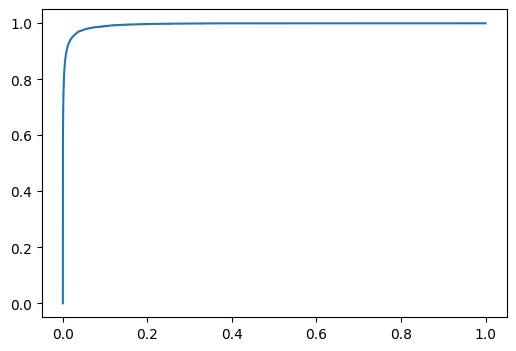

In [136]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [137]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9468891866227871
fbeta_score: 0.3918903823956511


,score,value
0,accuracy_score,0.946889
1,fbeta_score,0.391890


# Undersampling

## Data

In [138]:
print(df.shape)
df_wo_na = df.dropna()
print(df_wo_na.shape)

(307507, 544)
(102240, 544)


In [139]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [141]:
rus = RandomUnderSampler(random_state=0, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 70487, 1: 6193})
Resample dataset shape Counter({0: 6193, 1: 6193})


In [142]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_rus.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_rus = X_rus.rename(columns=new_names)

In [143]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

## LGBM

In [144]:
pipe = Pipeline([
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier()_19:30:26
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
- score_fbeta_test logged
Finished logging


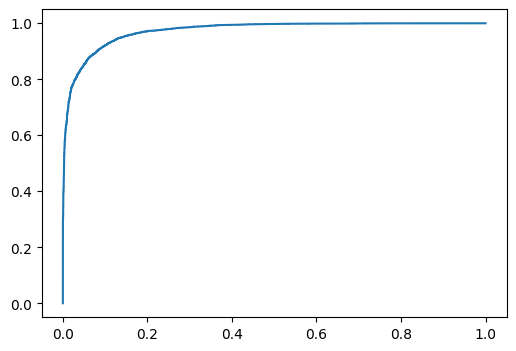

In [145]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [146]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
accuracy_score: 0.9585680751173709
fbeta_score: 0.547417940767668


,score,value
0,accuracy_score,0.958568
1,fbeta_score,0.547418


## Catboost

In [147]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

0:	learn: 0.6885250	total: 16.9ms	remaining: 1.67s
1:	learn: 0.6843903	total: 29.5ms	remaining: 1.45s
2:	learn: 0.6807620	total: 41.8ms	remaining: 1.35s
3:	learn: 0.6774964	total: 52.9ms	remaining: 1.27s
4:	learn: 0.6740294	total: 64.1ms	remaining: 1.22s
5:	learn: 0.6710307	total: 77ms	remaining: 1.21s
6:	learn: 0.6683020	total: 89.2ms	remaining: 1.18s
7:	learn: 0.6655597	total: 100ms	remaining: 1.15s
8:	learn: 0.6630679	total: 112ms	remaining: 1.14s
9:	learn: 0.6606860	total: 125ms	remaining: 1.13s
10:	learn: 0.6581075	total: 140ms	remaining: 1.13s
11:	learn: 0.6561172	total: 153ms	remaining: 1.12s
12:	learn: 0.6540970	total: 166ms	remaining: 1.11s
13:	learn: 0.6521613	total: 179ms	remaining: 1.1s
14:	learn: 0.6503892	total: 192ms	remaining: 1.09s
15:	learn: 0.6482565	total: 205ms	remaining: 1.08s
16:	learn: 0.6461074	total: 217ms	remaining: 1.06s
17:	learn: 0.6447633	total: 229ms	remaining: 1.04s
18:	learn: 0.6432299	total: 244ms	remaining: 1.04s
19:	learn: 0.6415731	total: 257ms	rem

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015F23AAC0>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015F23AAC0>_19:34:41
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.6516057	total: 44ms	remaining: 4.36s
1:	learn: 0.6159844	total: 86.2ms	remaining: 4.23s
2:	learn: 0.5836404	total: 124ms	remaining: 4.01s
3:	learn: 0.5522776	total: 160ms	remaining: 3.84s
4:	learn: 0.5262917	total: 201ms	remaining: 3.82s
5:	learn: 0.5009513	total: 242ms	remaining: 3.79s
6:	learn: 0.4795285	total: 285ms	remaining: 3.78s
7:	learn: 0.4587150	total: 331ms	remaining: 3.8s
8:	learn: 0.4396639	total: 377ms	remaining: 3.81s
9:	learn: 0.4240798	total: 422ms	remaining: 3.8s
10:	learn: 0.4101256	total: 465ms	remaining: 3.76s
11:	learn: 0.3970685	total: 514ms	remaining: 3.77s
12:	learn: 0.3857887	total:

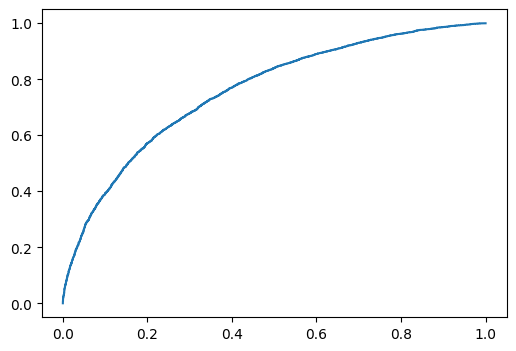

In [148]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [149]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.6516057	total: 47.9ms	remaining: 4.74s
1:	learn: 0.6159844	total: 91.5ms	remaining: 4.48s
2:	learn: 0.5836404	total: 136ms	remaining: 4.4s
3:	learn: 0.5522776	total: 178ms	remaining: 4.26s
4:	learn: 0.5262917	total: 218ms	remaining: 4.14s
5:	learn: 0.5009513	total: 260ms	remaining: 4.08s
6:	learn: 0.4795285	total: 303ms	remaining: 4.02s
7:	learn: 0.4587150	total: 344ms	remaining: 3.96s
8:	learn: 0.4396639	total: 386ms	remaining: 3.91s
9:	learn: 0.4240798	total: 428ms	remaining: 3.85s
10:	learn: 0.4101256	total: 464ms	remaining: 3.76s
11:	learn: 0.3970685	total: 511ms	remaining: 3.75s
12:	learn: 0.3857887	total: 549ms	remaining: 3.67s
13:	learn: 0.3753088	total: 591ms	remaining: 3.63s
14:	learn: 0.3661780	total: 631ms	remaining: 3.58s
15:	learn: 0.3579753	total: 669ms	remaining: 3.51s
16:	learn: 0.3497056	total: 714ms	remaining: 3.48s
17:	learn: 0.3426890	total: 756ms	remaining: 3.44s
18:	learn: 0.3362620	total: 799ms	remaining: 3.41s
19:	learn: 0.3294113	total: 838ms	remain

,score,value
0,accuracy_score,0.918545
1,fbeta_score,0.000000


## RandomForest

In [150]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(n_estimators=50)_19:36:31
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


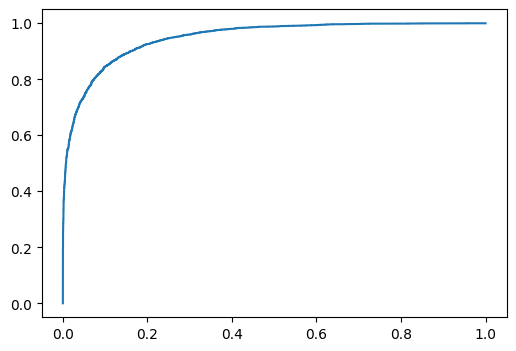

In [151]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [152]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.918661971830986
fbeta_score: 0.0018005041411595245


,score,value
0,accuracy_score,0.918662
1,fbeta_score,0.001801


# Class Weights

## Data

In [153]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [155]:
print('original dataset shape:', Counter(y_train))
print('weight class 0:', f'{Counter(y_train)[0]/y_train.shape[0]:.2f}', 'weight class 1:', f'{Counter(y_train)[1]/y_train.shape[0]:.2f}')

original dataset shape: Counter({0: 70487, 1: 6193})
weight class 0: 0.92 weight class 1: 0.08


In [156]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5439300863989104, 1: 6.1908606491199745}

In [157]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_train = X_train.rename(columns=new_names)

In [158]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

## LGBM

In [159]:
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced')),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: LGBMClassifier(class_weight='balanced')_19:40:47
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
- score_fbeta_test logged
Finished logging


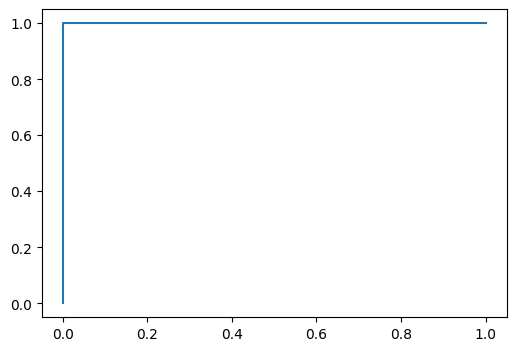

In [160]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [161]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
accuracy_score: 0.9999608763693271
fbeta_score: 0.9999039477475746


,score,value
0,accuracy_score,0.999961
1,fbeta_score,0.999904


## Catboost

In [162]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100, class_weights=class_weights)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

0:	learn: 0.6891834	total: 59.2ms	remaining: 5.86s
1:	learn: 0.6847271	total: 220ms	remaining: 10.8s
2:	learn: 0.6807672	total: 343ms	remaining: 11.1s
3:	learn: 0.6774739	total: 397ms	remaining: 9.53s
4:	learn: 0.6740395	total: 456ms	remaining: 8.67s
5:	learn: 0.6708415	total: 519ms	remaining: 8.12s
6:	learn: 0.6676961	total: 574ms	remaining: 7.62s
7:	learn: 0.6646888	total: 627ms	remaining: 7.21s
8:	learn: 0.6619007	total: 680ms	remaining: 6.87s
9:	learn: 0.6592362	total: 730ms	remaining: 6.57s
10:	learn: 0.6570068	total: 777ms	remaining: 6.28s
11:	learn: 0.6549860	total: 836ms	remaining: 6.13s
12:	learn: 0.6528567	total: 883ms	remaining: 5.91s
13:	learn: 0.6506084	total: 935ms	remaining: 5.74s
14:	learn: 0.6486299	total: 987ms	remaining: 5.59s
15:	learn: 0.6466767	total: 1.04s	remaining: 5.48s
16:	learn: 0.6449005	total: 1.1s	remaining: 5.39s
17:	learn: 0.6432341	total: 1.16s	remaining: 5.27s
18:	learn: 0.6419604	total: 1.21s	remaining: 5.15s
19:	learn: 0.6403189	total: 1.26s	remaini

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001015E362700>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001015E362700>_19:49:40
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.6693856	total: 767ms	remaining: 1m 15s
1:	learn: 0.6443920	total: 1.59s	remaining: 1m 17s
2:	learn: 0.6251099	total: 2.4s	remaining: 1m 17s
3:	learn: 0.6072981	total: 3.22s	remaining: 1m 17s
4:	learn: 0.5920997	total: 4.02s	remaining: 1m 16s
5:	learn: 0.5761396	total: 4.83s	remaining: 1m 15s
6:	learn: 0.5665680	total: 5.65s	remaining: 1m 15s
7:	learn: 0.5532892	total: 6.47s	remaining: 1m 14s
8:	learn: 0.5444069	total: 7.29s	remaining: 1m 13s
9:	learn: 0.5333147	total: 8.1s	remaining: 1m 12s
10:	learn: 0.5221713	total: 8.91s	remaining: 1m 12s
11:	learn: 0.5127330	total: 9.71s	remaining: 1m 11s
12:	learn: 0.50

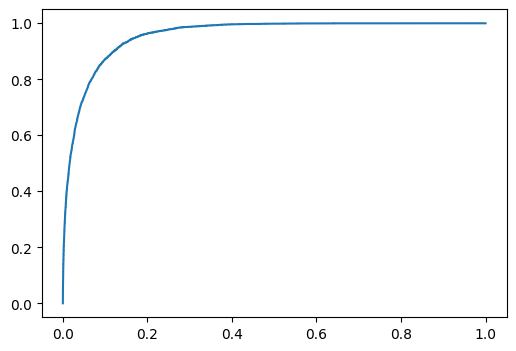

In [163]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [164]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.6693856	total: 968ms	remaining: 1m 35s
1:	learn: 0.6443920	total: 1.84s	remaining: 1m 30s
2:	learn: 0.6251099	total: 2.68s	remaining: 1m 26s
3:	learn: 0.6072981	total: 3.5s	remaining: 1m 23s
4:	learn: 0.5920997	total: 4.32s	remaining: 1m 22s
5:	learn: 0.5761396	total: 5.16s	remaining: 1m 20s
6:	learn: 0.5665680	total: 5.96s	remaining: 1m 19s
7:	learn: 0.5532892	total: 6.77s	remaining: 1m 17s
8:	learn: 0.5444069	total: 7.57s	remaining: 1m 16s
9:	learn: 0.5333147	total: 8.38s	remaining: 1m 15s
10:	learn: 0.5221713	total: 9.2s	remaining: 1m 14s
11:	learn: 0.5127330	total: 10s	remaining: 1m 13s
12:	learn: 0.5010244	total: 10.9s	remaining: 1m 12s
13:	learn: 0.4904953	total: 11.7s	remaining: 1m 11s
14:	learn: 0.4820336	total: 12.5s	remaining: 1m 11s
15:	learn: 0.4743842	total: 13.4s	remaining: 1m 10s
16:	learn: 0.4666187	total: 14.2s	remaining: 1m 9s
17:	learn: 0.4599274	total: 15s	remaining: 1m 8s
18:	learn: 0.4503786	total: 15.9s	remaining: 1m 7s
19:	learn: 0.4414523	total: 16.

,score,value
0,accuracy_score,0.971948
1,fbeta_score,0.935562


## RandomForest

In [165]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50, class_weight='balanced')),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=False)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-12" - id "601366048237866572"
Logging run: RandomForestClassifier(class_weight='balanced', n_estimators=50)_20:02:15
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


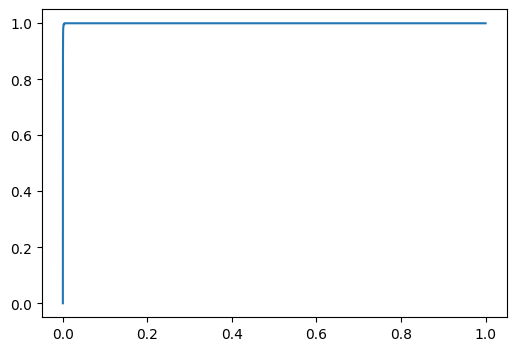

In [166]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [167]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9993348982785603
fbeta_score: 0.9951946179721288


,score,value
0,accuracy_score,0.999335
1,fbeta_score,0.995195


# Best model

In [168]:
best_model = search.best_estimator_[0]
best_model

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50)

In [169]:
# best_model = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, n_estimators=50)
# best_model

## Optimal threshold

In [170]:
thresholds = list(np.arange(0.1, 1.0, 0.1))
thresholds_list = []
scores_list = []

y_prob = best_model.predict_proba(X_test) #ou sur train ?

for threshold in thresholds:
    y_pred = (y_prob[:,1]>=threshold).astype(int)
    score = fbeta_score(y_test, y_pred, beta=2)

    thresholds_list.append(threshold)
    scores_list.append(score)

thresholds_df = pd.DataFrame({"threshold": thresholds_list, "score": scores_list})
thresholds_df

,threshold,score
0,0.1,0.692891
1,0.2,0.901143
2,0.3,0.975724
3,0.4,0.995982
4,0.5,0.995195
5,0.6,0.890884
6,0.7,0.461580
7,0.8,0.044037
8,0.9,0.000000


## Feature importance

In [171]:
# lgbm_best_model.best_estimator_.steps[2][1].feature_importances_
# lgbm_best_model.best_estimator_.steps[2][1]

In [172]:
# best_model = search.best_estimator_['model']
# best_model

In [173]:
# choosen_instance = X.loc[[0]]
choosen_instance = df.loc[[0]]

# explainer = shap.TreeExplainer(best_model.best_estimator_.steps[2][1])
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

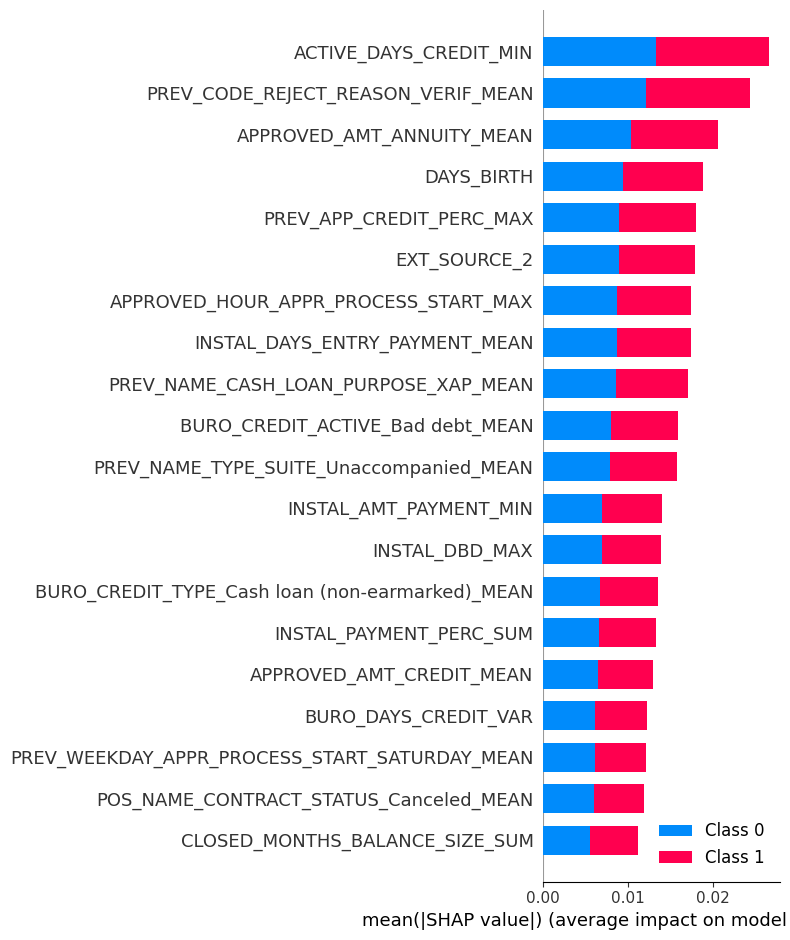

In [174]:
shap.summary_plot(shap_values, df, plot_type='bar')
# shap.summary_plotc